<a href="https://colab.research.google.com/github/hibaelhamydy/Examen-android/blob/master/RawGan_dental_augmented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RAW-GAN /




>Telecharger librairies (open3d,pytorch_3d,...)


In [1]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

# Set the path to the dental_dataset folder
folder_path = '/content/drive/MyDrive/vertices'

Mounted at /content/drive


In [2]:
!pip install "git+https://github.com/facebookresearch/pytorch3d.git"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/pytorch3d.git to /tmp/pip-req-build-8xxuqpgg
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-8xxuqpgg
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit f68371d3988cab39e1730281f97e91b62887b2a6
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch3d: filename=pytorch3d-0.7.4-cp310-cp310-linux_x86_64.whl size=58480264 sha256=890724296cf8c6168bd1c96e97286ad2c98e875bba4b06b6697757b8ba463cc0
  Stored in directory: /tmp/pip-ephem-wheel-cache-qtw7g7h5/wheels/dd/74/cc/b9266c863f19026f796e59a04e1cd9eb3754

In [3]:
!pip install matplotlib==3.2.2
!pip install plotly
!pip install open3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 16.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.2.2-cp310-cp310-linux_x86_64.whl size=12292110 sha256=74ab79eb46146d26ebc184df8148121623cf4a50b0e58ef6e2ca48bca655a86f
  Stored in directory: /root/.cache/pip/wheels/bb/81/f3/48b8bd245846ae69fcb2281c84e848bfea1f5260a870c148ae
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mizani 0.8.1 requires matplotlib>=3.5.0, but you have matplotlib 3.2.2 which is incompatible.
plotnine 0.10.1 requires matplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 85.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 99.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 89.5 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.4
    Uninstalling widgetsnbextension-3.6.4:
      Successful



> importation des librairies



In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from torch.autograd import Variable

from torchsummary import summary

#from torch_geometric.datasets import ModelNet, ShapeNet
#from torch_geometric.transforms import Compose, FixedPoints, SamplePoints, NormalizeScale

import os

import open3d as o3d

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import time

%matplotlib inline


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.__version__, device

('2.0.1+cu118', device(type='cuda'))



> Connexion a drive



In [6]:
#lecture des fichiers .ply et leur enregistrement sous format d'un tableau numpy et les telecharger sous format .npy
point_cloud_list = []
# Set the path to the dental_dataset folder
folder_path = '/content/drive/MyDrive/vertices'
# Get a list of file names in the folder_path directory
file_list = os.listdir(folder_path)

 #Loop over the .ply files
for file_name in file_list:
    # Construct the full path to each .ply file
    file_path = os.path.join(folder_path, file_name)

    #Read .ply file
    pcd = o3d.io.read_point_cloud(file_path)

    #Convert open3d format to numpy array
    point_cloud_in_numpy = np.asarray(pcd.points)

    #Append the numpy array to the point_cloud_list
    point_cloud_list.append(point_cloud_in_numpy)

In [7]:
# Save the point_cloud_list as .npy file
save_path = '/content/drive/MyDrive/3000_data.npy'
np.save(save_path, np.array(point_cloud_list))

In [8]:
pc1= np.load('/content/drive/MyDrive/3000_data.npy')

In [9]:
pc1.shape

(50, 3000, 3)



> Fonctions






> Lecture de données



In [10]:
class ReadDataset(Dataset):
    def __init__(self,  source):

        self.data = torch.from_numpy(source).float()


    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]



> Visualisation de données



In [11]:
def plotPCbatch(pcArray1, pcArray2, show = True, save = False, name=None, fig_count=9 , sizex = 18, sizey=6):

    pc1 = pcArray1[0:fig_count]
    pc2 = pcArray2[0:fig_count]

    fig=plt.figure(figsize=(sizex, sizey))

    for i in range(fig_count*2):

        ax = fig.add_subplot(2,fig_count,i+1, projection='3d')

        if(i<fig_count):
            ax.scatter(pc1[i,:,0], pc1[i,:,1], pc1[i,:,2], c='b', marker='.', alpha=0.8, s=8)
        else:
            ax.scatter(pc2[i-fig_count,:,0], pc2[i-fig_count,:,1], pc2[i-fig_count,:,2], c='b', marker='.', alpha=0.8, s=8)

        ax.set_xlim3d(0, 1)
        ax.set_ylim3d(0, 1)
        ax.set_zlim3d(0, 1)
        #ax.view_init(50, 20)

    plt.subplots_adjust(wspace=0, hspace=0)
    if(save):
        fig.savefig(name + '.png')
        plt.close(fig)

    if(show):
        plt.show()
    else:
        return fig

In [12]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import numpy as np
import matplotlib.pyplot as plt
def visualize_mesh(pos, face):
    # from the tutorial https://colab.research.google.com/drive/1D45E5bUK3gQ40YpZo65ozs7hg5l-eo_U?usp=sharing#scrollTo=SvsEAR28LUI7
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([])
    ax.plot_trisurf(pos[:, 0], pos[:, 1], pos[:, 2], triangles=face.t(), antialiased=False)
    plt.show()


def visualize_points(points, ax=None, show_grid=False, is_shapenet=False):
    fig = plt.figure()
    if ax is None:
        ax = fig.add_subplot(projection='3d')
    ax.patch.set_alpha(0)
    ax.view_init(elev=10., azim=240.)
    ax.grid(show_grid)
    if is_shapenet:
      ax.scatter(points[:,0], points[:,2], points[:,1], c=points[:,2], cmap='plasma', s=10)
    else:
      ax.scatter(points[:,0], points[:,1], points[:,2], c=points[:,1], cmap='plasma', s=10)


def visualize_real_and_generated_samples(samples, show_grid=False, is_shapenet=False):
    fig = plt.figure(figsize=(16, 8))
    for i, sample in enumerate(samples):
        ax = fig.add_subplot(1, 2, i+1, projection='3d')
        visualize_points(sample, ax, show_grid, is_shapenet)

def visualize_points_3d(points, show_grid=False, is_shapenet=False):
    fig = go.Figure()

    if is_shapenet:
        fig.add_trace(go.Scatter3d(
            x=points[:, 0],
            y=points[:, 2],
            z=points[:, 1],
            mode='markers',
            marker=dict(
                size=10,
                color=points[:, 2],
                colorscale='plasma',
                opacity=1.0
            )
        ))
    else:
        fig.add_trace(go.Scatter3d(
            x=points[:, 0],
            y=points[:, 1],
            z=points[:, 2],
            mode='markers',
            marker=dict(
                size=10,
                color=points[:, 1],
                colorscale='plasma',
                opacity=1.0
            )
        ))

    fig.update_layout(scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False),
        aspectmode='cube'
    ))

    fig.update_layout(showlegend=False)

    fig.show()




> Fonctions DataLoader SplitData



In [13]:
def GetDataLoaders(npArray, batch_size, train_set_percentage = 0.9, shuffle=True, num_workers=0, pin_memory=True):


    pc = ReadDataset(npArray)

    train_set, test_set = RandomSplit(pc, train_set_percentage)

    train_loader = DataLoader(train_set, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size, pin_memory=pin_memory)
    test_loader = DataLoader(test_set, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size, pin_memory=pin_memory)

    return train_loader, test_loader

In [14]:
def RandomSplit(datasets, train_set_percentage):
    lengths = [int(len(datasets)*train_set_percentage), len(datasets)-int(len(datasets)*train_set_percentage)]
    return random_split(datasets, lengths)



> Visualiser un echentillon



In [15]:
import plotly.graph_objects as go
fig = plt.figure(figsize=(7,7))
a=pc1[35]

visualize_points_3d(a)

<Figure size 700x700 with 0 Axes>



> Augmentation des données (rotation et scaling)



In [16]:
def rotate_point_cloud(batch_data):
    """ Randomly rotate the point clouds to augment the dataset.
        Rotation is performed per shape along the up direction.
        Input:
          BxNx3 array, original batch of point clouds
        Return:
          BxNx3 array, rotated batch of point clouds
    """
    rotated_data = np.zeros(batch_data.shape, dtype=np.float32)
    for k in range(batch_data.shape[0]):
        rotation_angle = np.random.uniform() * 2 * np.pi
        cosval = np.cos(rotation_angle)
        sinval = np.sin(rotation_angle)
        rotation_matrix = np.array([[cosval, 0, sinval],
                                    [0, 1, 0],
                                    [-sinval, 0, cosval]])
        shape_pc = batch_data[k, ...]
        rotated_data[k, ...] = np.dot(shape_pc.reshape((-1, 3)), rotation_matrix)
    return rotated_data

In [17]:
degrees=[]
for i in range(36):
    degrees.append(i*10)

In [18]:
def Normalize(Points):
    assert len(Points.shape)==2

    norm_pointcloud = Points - np.mean(Points, axis=0)
    norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

    return  norm_pointcloud

In [19]:
#rotation

def rotation_Z(v,degrees):

    arrayOfRotatedObjectsz=[]
    verts=v
    for i in degrees:
        theta = np.radians(i)
        A = np.array(((np.cos(theta), -np.sin(theta), 0),
                      (np.sin(theta), np.cos(theta), 0),
                      (0, 0, 1)), dtype=verts.dtype)

        Object_rotatedz=A.dot(verts.T).T
        arrayOfRotatedObjectsz.append(Object_rotatedz)


    return arrayOfRotatedObjectsz

# rotate x
def rotation_x(v,degrees):
    arrayOfRotatedObjectsx=[]
    verts=v
    for i in degrees:
        theta = np.radians(i)
        A = np.array(((1, 0, 0),
                  (0, np.cos(theta), -np.sin(theta)),
                  (0, np.sin(theta), np.cos(theta))),dtype=verts.dtype)

        Object_rotatedx=A.dot(verts.T).T
        arrayOfRotatedObjectsx.append(Object_rotatedx)


    return arrayOfRotatedObjectsx

# rotate y
def rotation_y(v,degrees):
    arrayOfRotatedObjectsy=[]
    verts=v
    for i in degrees:
        theta = np.radians(i)
        A = np.array(((np.cos(theta), 0, -np.sin(theta)),
                  (0, 1, 0),
                  (np.sin(theta), 0, np.cos(theta))),dtype=verts.dtype)

        Object_rotatedy=A.dot(verts.T).T
        arrayOfRotatedObjectsy.append(Object_rotatedy)


    return arrayOfRotatedObjectsy



> Visualiser un echentillon



<Figure size 700x700 with 0 Axes>

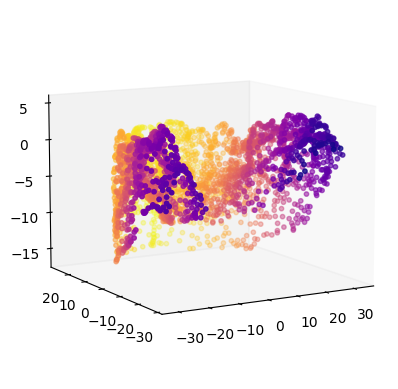

In [20]:
fig = plt.figure(figsize=(7,7))
a=pc1[3]

visualize_points(a)



> Augmentation de données



In [21]:
#normalisation
normalized_dataset = []
for pc in pc1:
    normalized_item = Normalize(pc)
    normalized_dataset.append(normalized_item)
normalized_data = np.array(normalized_dataset)
normalized_data.shape

(50, 3000, 3)

In [22]:
# Rotate all objects first
rotated_dataset = []

for point_cloud in normalized_data:
    rotated_clouds_x = rotation_x(point_cloud, degrees)
    rotated_clouds_y = rotation_y(point_cloud, degrees)
    rotated_clouds_z = rotation_Z(point_cloud, degrees)

    rotated_dataset.append(rotated_clouds_x)
    rotated_dataset.append(rotated_clouds_y)
    rotated_dataset.append(rotated_clouds_z)

rotated_data = np.concatenate(rotated_dataset, axis=0)
rotated_data.shape

(5400, 3000, 3)



> Lecture données apres augmentation



In [41]:
pc = ReadDataset(rotated_data)
pc1=ReadDataset(normalized_data)
new_data = rotated_data
print(new_data.shape)

# load dataset from numpy array and divide 90%-10% randomly for train and test sets
train_loader, test_loader = GetDataLoaders(npArray=new_data, batch_size=32)

# Assuming all models have the same size, get the point size from the first model
point_size = len(train_loader.dataset[1])
print(point_size)

(5400, 3000, 3)
3000


In [24]:
import plotly.graph_objects as go
visualize_points_3d(new_data[4001])



> Metriques d'evaluation



**Coverage and fidelity**

In [25]:
def coverage(real_clouds, gen_clouds, distance_fn):
    matches = [ torch.argmin(torch.as_tensor([distance_fn(a, b) for b in real_clouds])) for a in gen_clouds ]
    score = len(torch.unique(matches)) / len(gen_clouds)
    return score


def fidelity(real_clouds, gen_clouds, distance_fn):
    distances = [ [distance_fn(a, b) for b in gen_clouds] for a in real_clouds ]
    distances = torch.as_tensor(distances)

    min_distances = distances.min(dim=-1)

    score = torch.mean(min_distances)

    return score

**the chamfer loss module code**

In [26]:

from typing import Union

import torch
import torch.nn.functional as F
from pytorch3d.ops.knn import knn_gather, knn_points
from pytorch3d.structures.pointclouds import Pointclouds


def _validate_chamfer_reduction_inputs(
    batch_reduction: Union[str, None], point_reduction: str
) -> None:

    if batch_reduction is not None and batch_reduction not in ["mean", "sum"]:
        raise ValueError('batch_reduction must be one of ["mean", "sum"] or None')
    if point_reduction not in ["mean", "sum"]:
        raise ValueError('point_reduction must be one of ["mean", "sum"]')


def _handle_pointcloud_input(
    points: Union[torch.Tensor, Pointclouds],
    lengths: Union[torch.Tensor, None],
    normals: Union[torch.Tensor, None],
):
    if isinstance(points, Pointclouds):
        X = points.points_padded()
        lengths = points.num_points_per_cloud()
        normals = points.normals_padded()  # either a tensor or None
    elif torch.is_tensor(points):
        if points.ndim != 3:
            raise ValueError("Expected points to be of shape (N, P, D)")
        X = points
        if lengths is not None:
            if lengths.ndim != 1 or lengths.shape[0] != X.shape[0]:
                raise ValueError("Expected lengths to be of shape (N,)")
            if lengths.max() > X.shape[1]:
                raise ValueError("A length value was too long")
        if lengths is None:
            lengths = torch.full(
                (X.shape[0],), X.shape[1], dtype=torch.int64, device=points.device
            )
        if normals is not None and normals.ndim != 3:
            raise ValueError("Expected normals to be of shape (N, P, 3")
    else:
        raise ValueError(
            "The input pointclouds should be either "
            + "Pointclouds objects or torch.Tensor of shape "
            + "(minibatch, num_points, 3)."
        )
    return X, lengths, normals


def chamfer_distance(
    x,
    y,
    x_lengths=None,
    y_lengths=None,
    x_normals=None,
    y_normals=None,
    weights=None,
    batch_reduction: Union[str, None] = "mean",
    point_reduction: str = "mean",
    norm: int = 2,
):

    _validate_chamfer_reduction_inputs(batch_reduction, point_reduction)

    if not ((norm == 1) or (norm == 2)):
        raise ValueError("Support for 1 or 2 norm.")

    x, x_lengths, x_normals = _handle_pointcloud_input(x, x_lengths, x_normals)
    y, y_lengths, y_normals = _handle_pointcloud_input(y, y_lengths, y_normals)

    return_normals = x_normals is not None and y_normals is not None

    N, P1, D = x.shape
    P2 = y.shape[1]

    # Check if inputs are heterogeneous and create a lengths mask.
    is_x_heterogeneous = (x_lengths != P1).any()
    is_y_heterogeneous = (y_lengths != P2).any()
    x_mask = (
        torch.arange(P1, device=x.device)[None] >= x_lengths[:, None]
    )  # shape [N, P1]
    y_mask = (
        torch.arange(P2, device=y.device)[None] >= y_lengths[:, None]
    )  # shape [N, P2]

    if y.shape[0] != N or y.shape[2] != D:
        raise ValueError("y does not have the correct shape.")
    if weights is not None:
        if weights.size(0) != N:
            raise ValueError("weights must be of shape (N,).")
        if not (weights >= 0).all():
            raise ValueError("weights cannot be negative.")
        if weights.sum() == 0.0:
            weights = weights.view(N, 1)
            if batch_reduction in ["mean", "sum"]:
                return (
                    (x.sum((1, 2)) * weights).sum() * 0.0,
                    (x.sum((1, 2)) * weights).sum() * 0.0,
                )
            return ((x.sum((1, 2)) * weights) * 0.0, (x.sum((1, 2)) * weights) * 0.0)

    cham_norm_x = x.new_zeros(())
    cham_norm_y = x.new_zeros(())

    x_nn = knn_points(x, y, lengths1=x_lengths, lengths2=y_lengths, norm=norm, K=1)
    y_nn = knn_points(y, x, lengths1=y_lengths, lengths2=x_lengths, norm=norm, K=1)

    cham_x = x_nn.dists[..., 0]  # (N, P1)
    cham_y = y_nn.dists[..., 0]  # (N, P2)

    if is_x_heterogeneous:
        cham_x[x_mask] = 0.0
    if is_y_heterogeneous:
        cham_y[y_mask] = 0.0

    if weights is not None:
        cham_x *= weights.view(N, 1)
        cham_y *= weights.view(N, 1)

    if return_normals:
        # Gather the normals using the indices and keep only value for k=0
        x_normals_near = knn_gather(y_normals, x_nn.idx, y_lengths)[..., 0, :]
        y_normals_near = knn_gather(x_normals, y_nn.idx, x_lengths)[..., 0, :]

        cham_norm_x = 1 - torch.abs(
            F.cosine_similarity(x_normals, x_normals_near, dim=2, eps=1e-6)
        )
        cham_norm_y = 1 - torch.abs(
            F.cosine_similarity(y_normals, y_normals_near, dim=2, eps=1e-6)
        )

        if is_x_heterogeneous:
            cham_norm_x[x_mask] = 0.0
        if is_y_heterogeneous:
            cham_norm_y[y_mask] = 0.0

        if weights is not None:
            cham_norm_x *= weights.view(N, 1)
            cham_norm_y *= weights.view(N, 1)

    # Apply point reduction
    cham_x = cham_x.sum(1)  # (N,)
    cham_y = cham_y.sum(1)  # (N,)
    if return_normals:
        cham_norm_x = cham_norm_x.sum(1)  # (N,)
        cham_norm_y = cham_norm_y.sum(1)  # (N,)
    if point_reduction == "mean":
        x_lengths_clamped = x_lengths.clamp(min=1)
        y_lengths_clamped = y_lengths.clamp(min=1)
        cham_x /= x_lengths_clamped
        cham_y /= y_lengths_clamped
        if return_normals:
            cham_norm_x /= x_lengths_clamped
            cham_norm_y /= y_lengths_clamped

    if batch_reduction is not None:
        # batch_reduction == "sum"
        cham_x = cham_x.sum()
        cham_y = cham_y.sum()
        if return_normals:
            cham_norm_x = cham_norm_x.sum()
            cham_norm_y = cham_norm_y.sum()
        if batch_reduction == "mean":
            div = weights.sum() if weights is not None else max(N, 1)
            cham_x /= div
            cham_y /= div
            if return_normals:
                cham_norm_x /= div
                cham_norm_y /= div

    cham_dist = cham_x + cham_y
    cham_normals = cham_norm_x + cham_norm_y if return_normals else None

    return cham_dist, cham_normals

**Implementation**

In [27]:
class ChamferLoss(nn.Module):
    def __init__(self, point_reduction='sum'):
        super(ChamferLoss, self).__init__()
        self.point_reduction = point_reduction

    def forward(self, x, y):
        # https://pytorch3d.readthedocs.io/en/latest/_modules/pytorch3d/loss/chamfer.html
        chamfer_dist, chamfer_normals = chamfer_distance(x, y, point_reduction=self.point_reduction)
        return chamfer_dist

In [28]:
torch.manual_seed(11)

n_points = 3000

## Raw GAN (r-GAN)

(See https://arxiv.org/pdf/1707.02392.pdf)

**Generator**

Input  128 --->  Linear 64 + ReLU  ---> Linear 128 + ReLU ---> Linear 512 + ReLU --->  Linear 1024 + ReLU  --->  Linear 2048*3

<br></br>

**Discriminator**

Input 2048x3 --->

ENCODER

Conv1D (2048, 64, kernel_size=1)   + LeakyReLU  --->
Conv1D (64, 128, kernel_size=1)    + LeakyReLU --->
Conv1D (128, 256, kernel_size=1)   + LeakyReLU  --->
Conv1D (256, 256, kernel_size=1)   + LeakyReLU  --->
Conv1D (256, 512, kernel_size=1)   + LeakyReLU  --->
(output.shape = (512, 3))

--->

DECODER

--->  Linear(512, 128) + ReLU ---> Linear(128, 64) + ReLU --->
--->  Linear(64, 1) + Sigmoid ---> Fake or Real


In [29]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(True),
            nn.Linear(64, 128), nn.ReLU(True),
            nn.Linear(128, 512), nn.ReLU(True),
            nn.Linear(512, 1024), nn.ReLU(True),
            nn.Linear(1024, output_dim)
        )

    def forward(self, x):
        # reshape to batch_size x 3 x n_points
        samples = self.model(x).view(x.size(0), 3, -1)

        # TODO: try clipping the output to be in [-1, 1], e.g., by applying tanh
        # samples.clamp_(min=-1, max=1)

        return samples

    def init_params(self, layer):
        if type(layer) == nn.Linear:
            nn.init.xavier_uniform_(layer.weight.data)
            nn.init.zeros_(layer.bias.data)

In [30]:
# instantiate the r-GAN generator
raw_gan_gen_input_dim = 128
raw_gan_gen = Generator(raw_gan_gen_input_dim, n_points*3).to(device)

# initialize the parameters:
raw_gan_gen.apply(raw_gan_gen.init_params)

mu = 0.
sigma = 0.2

z = torch.FloatTensor(1, raw_gan_gen_input_dim).normal_(mu, sigma).to(device)

print(z.shape)
print(raw_gan_gen(z).shape)

summary(raw_gan_gen, (1, raw_gan_gen_input_dim))

torch.Size([1, 128])
torch.Size([1, 3, 3000])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]           8,256
              ReLU-2                [-1, 1, 64]               0
            Linear-3               [-1, 1, 128]           8,320
              ReLU-4               [-1, 1, 128]               0
            Linear-5               [-1, 1, 512]          66,048
              ReLU-6               [-1, 1, 512]               0
            Linear-7              [-1, 1, 1024]         525,312
              ReLU-8              [-1, 1, 1024]               0
            Linear-9              [-1, 1, 9000]       9,225,000
Total params: 9,832,936
Trainable params: 9,832,936
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
Params size (MB): 37.51
Estimated Total Size (MB

In [31]:
class Discriminator(nn.Module):
    def __init__(self, encoder_in_ch, encoder_out_ch):
        super(Discriminator, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(encoder_in_ch, 64, 1, 1), nn.LeakyReLU(0.2),
            nn.Conv1d(64, 128, 1, 1), nn.LeakyReLU(0.2),
            nn.Conv1d(128, 256, 1, 1), nn.LeakyReLU(0.2),
            nn.Conv1d(256, 256, 1, 1), nn.LeakyReLU(0.2),
            nn.Conv1d(256, encoder_out_ch, 1, 1), nn.LeakyReLU(0.2)
        )
        # outputs (batch_size x encoder_out_ch x n_points)
        # we then maxpool the output in the forward method,
        # so the input to the decoder becomes (batch_size x encoder_out_ch)

        self.decoder = nn.Sequential(
            nn.Linear(encoder_out_ch, 128), nn.ReLU(True),
            nn.Linear(128, 64), nn.ReLU(True),
            nn.Linear(64, 1), nn.Sigmoid(),
        )


    def forward(self, x):
        x = self.encoder(x)
        x, _ = torch.max(x, dim=-1)
        x = self.decoder(x)
        return x


    def init_params(self, layer):
        if type(layer) == nn.Conv1d:
            nn.init.kaiming_uniform_(layer.weight.data)
            nn.init.zeros_(layer.bias.data)
        if type(layer) == nn.Linear:
            nn.init.xavier_uniform_(layer.weight.data)
            nn.init.zeros_(layer.bias.data)

In [32]:
# instantiate the r-GAN discriminator:
raw_gan_dis_input_ch = 3
raw_gan_dis = Discriminator(raw_gan_dis_input_ch, 512).to(device)

# initialize the parameters:
raw_gan_dis.apply(raw_gan_dis.init_params)

# print the summary:
y = torch.ones((1, 3, 3000)).to(device)
print(y.shape)

pred = raw_gan_dis(y)
print(pred.shape)

summary(raw_gan_dis, (raw_gan_dis_input_ch, 3000))

torch.Size([1, 3, 3000])
torch.Size([1, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 3000]             256
         LeakyReLU-2             [-1, 64, 3000]               0
            Conv1d-3            [-1, 128, 3000]           8,320
         LeakyReLU-4            [-1, 128, 3000]               0
            Conv1d-5            [-1, 256, 3000]          33,024
         LeakyReLU-6            [-1, 256, 3000]               0
            Conv1d-7            [-1, 256, 3000]          65,792
         LeakyReLU-8            [-1, 256, 3000]               0
            Conv1d-9            [-1, 512, 3000]         131,584
        LeakyReLU-10            [-1, 512, 3000]               0
           Linear-11                  [-1, 128]          65,664
             ReLU-12                  [-1, 128]               0
           Linear-13                   [-1, 64]           8

## Optimize the r-GAN

### Optimization setup

In [33]:
# hyperparameters:
lr_gen = 1e-4
lr_dis = 1e-4
beta1 = 0.5
beta2 = 0.999

# two separate optimizers for the generator and discriminator:
optimizer_gen = optim.Adam(params=raw_gan_gen.parameters(),
                           lr=lr_gen,
                           betas=(beta1, beta2))

optimizer_dis = optim.Adam(params=raw_gan_dis.parameters(),
                           lr=lr_dis,
                           betas=(beta1, beta2))

# by supplying with the correct labels, we will make it
# equivalent to using non-saturating heuristic for the generator
# and the standard binary cross-entropy for the discriminator
criterion = nn.BCELoss().to(device)
criterion_gen = criterion # nn.BCELoss().to(device)
criterion_dis = criterion # nn.BCELoss().to(device)

### Create a dataloader for our single class dataset

### Create a dataloader for our single class dataset

In [57]:
batch_size = 64
dataloader = DataLoader(dataset=pc,
                        batch_size=batch_size,
                        shuffle=True,
                        drop_last=True)

print('Batch size: ', batch_size)
print('Number of batches:', len(dataloader))

Batch size:  64
Number of batches: 84


### Training loop

In [58]:
epochs = 150
print_period = 50

losses_gen = []
losses_dis = []

for i in range(epochs):
    t0 = time.time()

    for batch_idx, batch_data in enumerate(dataloader):
        print(batch_idx, end='\r')
        batch_t0 = time.time()
        batch_size = 64

        x = batch_data.transpose(2, 1).to(device)

        # sample random vectors and generate samples from them:
        z = torch.FloatTensor(batch_size, raw_gan_gen_input_dim).normal_(mu, sigma).to(device)
        gen_samples = raw_gan_gen(z)

        # get the discriminator output for the two types of input:
        prob_x = raw_gan_dis(x)
        prob_gen_samples = raw_gan_dis(gen_samples)

        # the target probabilities:
        prob_real = torch.ones((batch_size, 1)).to(device)
        prob_fake = torch.zeros((batch_size, 1)).to(device)

        # the non-saturating heuristic loss for the generator:
        loss_gen = criterion_gen(prob_gen_samples, prob_real)

        # compute the gradient of the loss_gen wrt the generator parameters:
        optimizer_gen.zero_grad()
        loss_gen.backward(retain_graph=True)

        # update the generator parameters:
        optimizer_gen.step()
        losses_gen.append(loss_gen.item())

        # update the discrimiator parameters twice as rarely:
        # if batch_idx % 2 == 0:
        # the usual (binary cross-entropy) loss for the discriminator:
        loss_dis_real_term = criterion_dis(prob_x, prob_real)
        loss_dis_fake_term = criterion_dis(raw_gan_dis(gen_samples.detach()), prob_fake)
        loss_dis = loss_dis_real_term + loss_dis_fake_term

        # compute the gradient and update the discriminator parameters:
        optimizer_dis.zero_grad()
        loss_dis.backward()
        optimizer_dis.step()
        losses_dis.append(loss_dis.item())

        if batch_idx % print_period == 0:
            print('ETA: %.5f, epoch: %d/%d, batch: %d/%d, loss_gen: %.3f, loss_dis: %.3f'
              % (time.time() - batch_t0, i+1, epochs, batch_idx, len(dataloader), torch.mean(torch.FloatTensor(losses_gen)), torch.mean(torch.FloatTensor(losses_dis)))
            )

    print('ETA: %.5f' % (time.time() - t0), end='\n\n')

ETA: 0.34481, epoch: 1/150, batch: 0/84, loss_gen: 5.869, loss_dis: 0.171
ETA: 0.28530, epoch: 1/150, batch: 50/84, loss_gen: 3.202, loss_dis: 0.258
ETA: 24.31043

ETA: 0.29188, epoch: 2/150, batch: 0/84, loss_gen: 3.010, loss_dis: 0.316
ETA: 0.29390, epoch: 2/150, batch: 50/84, loss_gen: 3.141, loss_dis: 0.240
ETA: 24.66734

ETA: 0.29197, epoch: 3/150, batch: 0/84, loss_gen: 3.150, loss_dis: 0.212
ETA: 0.29439, epoch: 3/150, batch: 50/84, loss_gen: 3.325, loss_dis: 0.196
ETA: 25.00872

ETA: 0.29883, epoch: 4/150, batch: 0/84, loss_gen: 3.488, loss_dis: 0.208
ETA: 0.30134, epoch: 4/150, batch: 50/84, loss_gen: 3.543, loss_dis: 0.211
ETA: 25.39246

ETA: 0.29631, epoch: 5/150, batch: 0/84, loss_gen: 3.645, loss_dis: 0.212
ETA: 0.30190, epoch: 5/150, batch: 50/84, loss_gen: 3.590, loss_dis: 0.205
ETA: 25.54477

ETA: 0.29914, epoch: 6/150, batch: 0/84, loss_gen: 3.545, loss_dis: 0.203
ETA: 0.30299, epoch: 6/150, batch: 50/84, loss_gen: 3.552, loss_dis: 0.189
ETA: 25.54528

ETA: 0.30652, ep

### Plot the losses

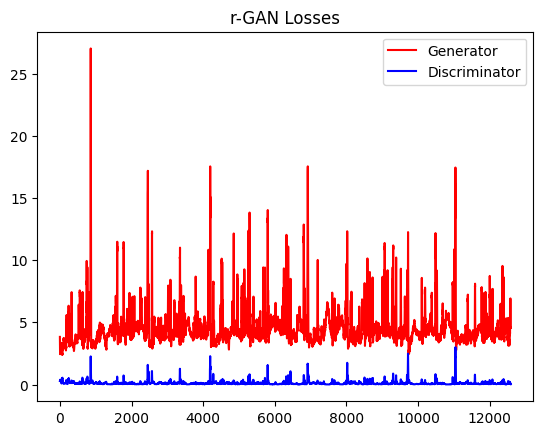

In [59]:
def running_mean(data, periods=10):
    # from https://github.com/artemsavkin/latent3d/blob/master/pcl_latent3d_shapenet.ipynb
    weights = np.ones(periods) / periods
    return np.convolve(data, weights, mode='valid')

rm_losses_gen = running_mean(np.asarray(losses_gen))
rm_losses_dis = running_mean(np.asarray(losses_dis))


plt.plot(range(0, len(rm_losses_gen)), rm_losses_gen, 'r-', label='Generator')
plt.plot(range(0, len(rm_losses_dis)), rm_losses_dis, 'b-', label='Discriminator')
plt.gca().patch.set_alpha(0)
plt.title('r-GAN Losses')
plt.legend()
plt.show()

## Save the model

In [60]:

torch.save(
    {
      'raw_gan_generator': raw_gan_gen.state_dict(),
      'raw_gan_discriminator': raw_gan_dis.state_dict()
    },
    '/content/drive/MyDrive/_l_gan_dental_raw_gan_aug.tar'
    )


In [61]:
loaded_model = torch.load('/content/drive/MyDrive/_l_gan_dental_raw_gan_aug.tar', map_location=device)
loaded_model['raw_gan_generator']

OrderedDict([('model.0.weight',
              tensor([[ 0.0277,  0.0126,  0.0181,  ..., -0.0197, -0.0178,  0.0120],
                      [-0.0302,  0.0051, -0.0018,  ...,  0.0184,  0.0196,  0.0064],
                      [-0.0080, -0.0125,  0.0050,  ...,  0.0024, -0.0178, -0.0042],
                      ...,
                      [ 0.0404,  0.0352,  0.0142,  ..., -0.0115, -0.0196,  0.0172],
                      [ 0.0100,  0.0071,  0.0245,  ..., -0.0183, -0.0047,  0.0256],
                      [ 0.0098,  0.0018, -0.0006,  ...,  0.0241, -0.0230,  0.0096]],
                     device='cuda:0')),
             ('model.0.bias',
              tensor([-0.1696, -0.2199, -0.1556, -0.2510, -0.1797, -0.1743, -0.2306, -0.1696,
                      -0.1691, -0.2091, -0.2069, -0.2147, -0.1924, -0.1903, -0.2224, -0.2163,
                      -0.1693, -0.1783, -0.2318, -0.2076, -0.2269, -0.2167, -0.2224, -0.1851,
                      -0.1840, -0.1632, -0.1621, -0.1719, -0.2126, -0.2378, -0.2325,

### Generate samples

(64, 3, 3000)
(64, 3, 3000)


<ipython-input-12-a15ef9f25d02>:16: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



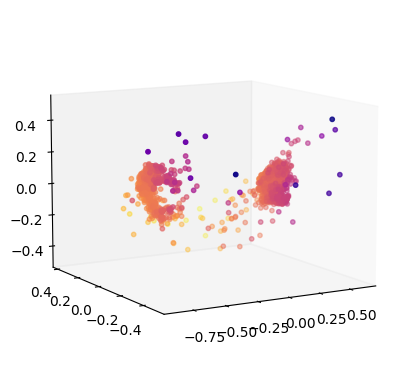

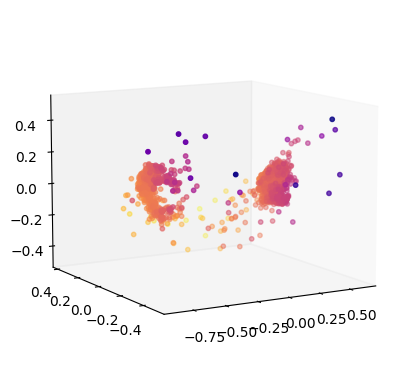

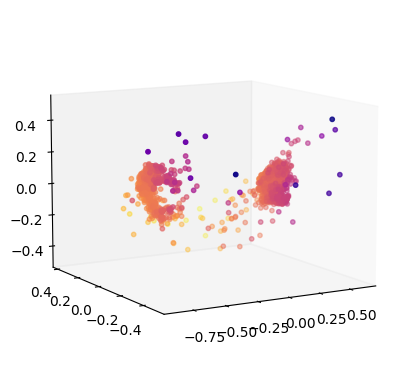

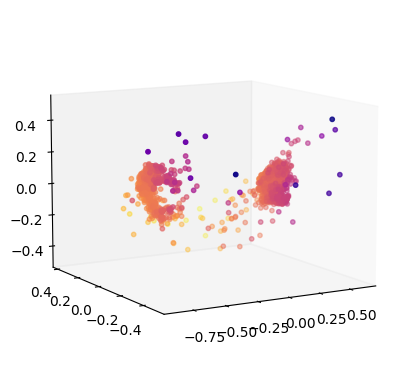

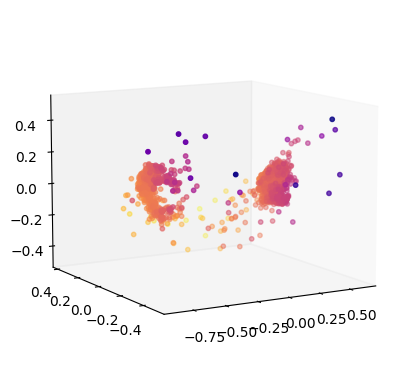

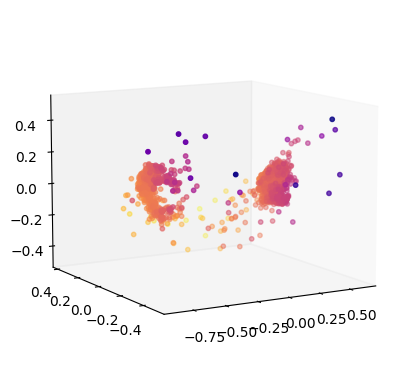

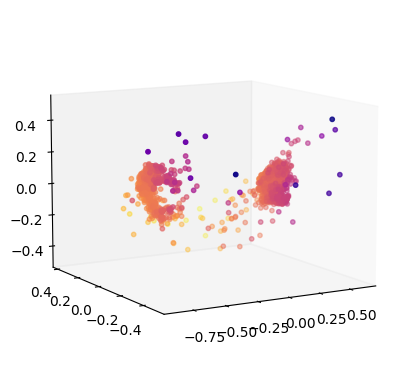

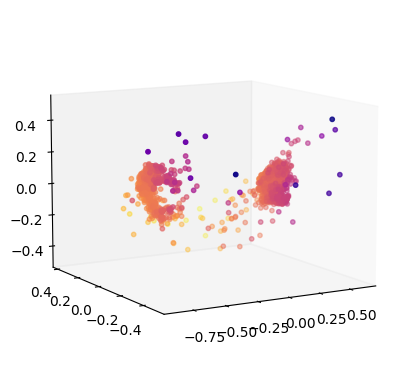

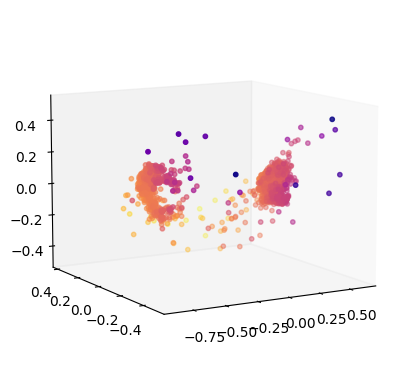

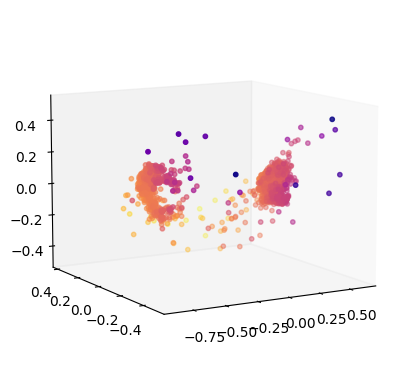

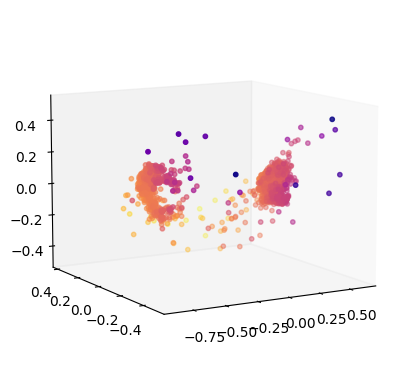

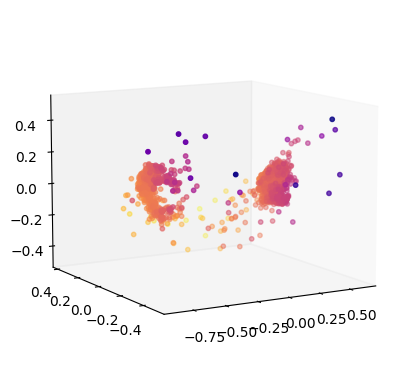

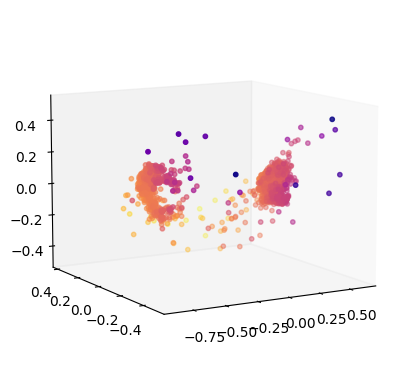

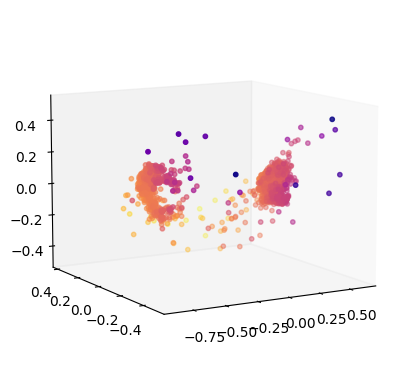

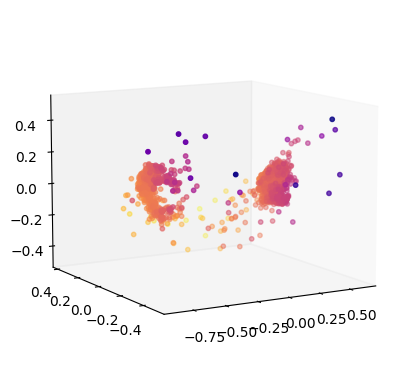

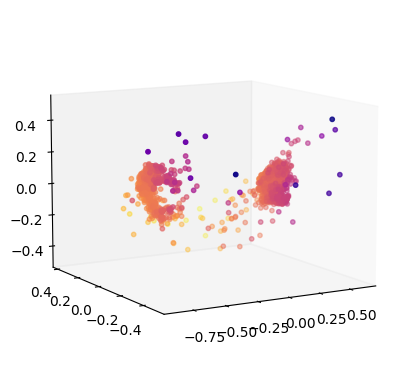

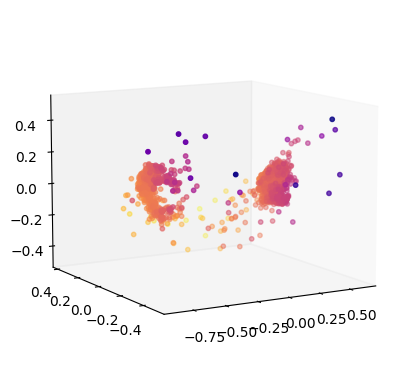

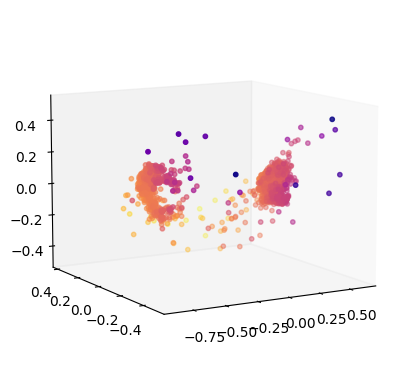

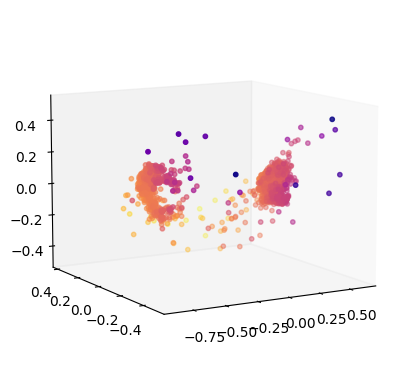

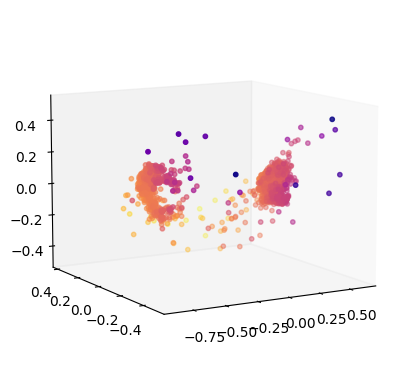

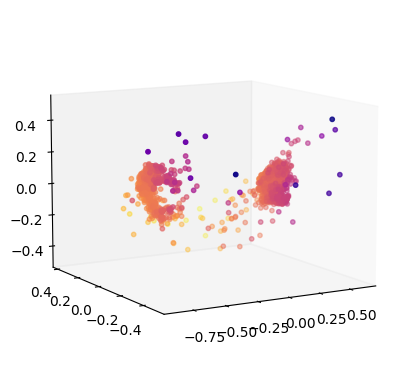

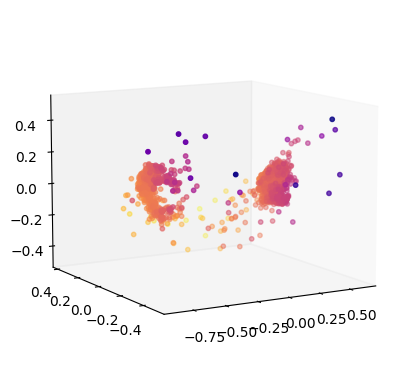

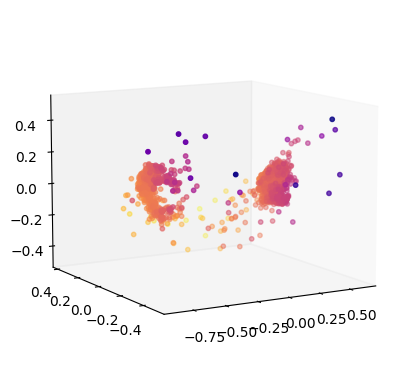

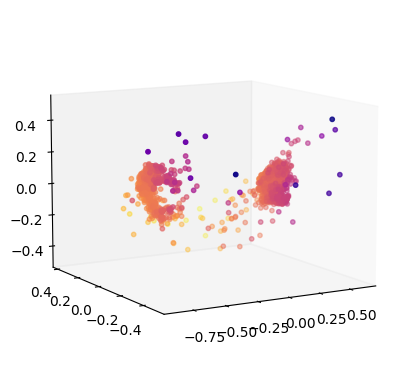

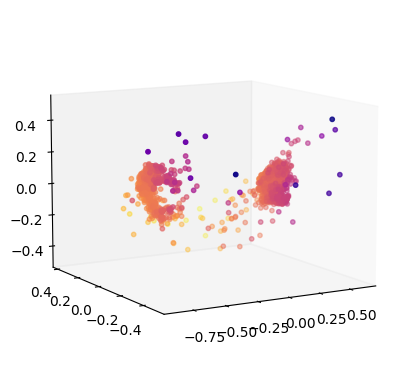

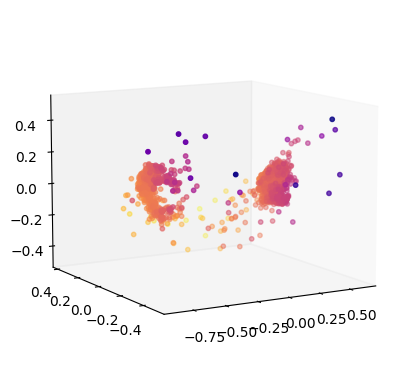

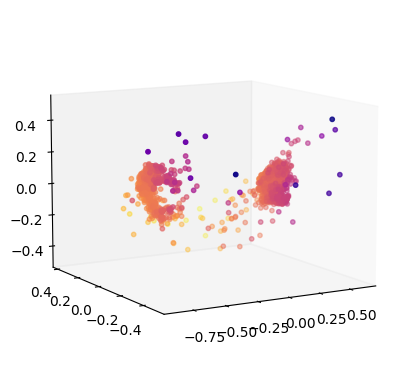

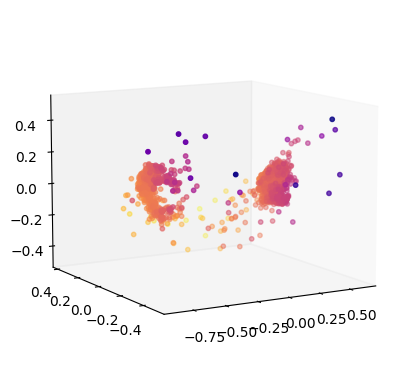

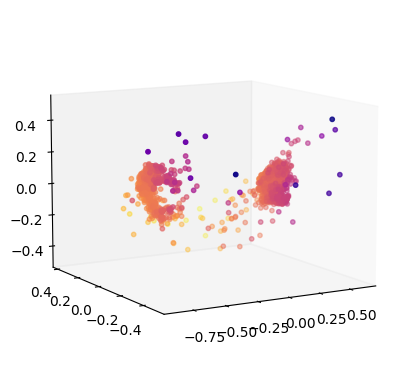

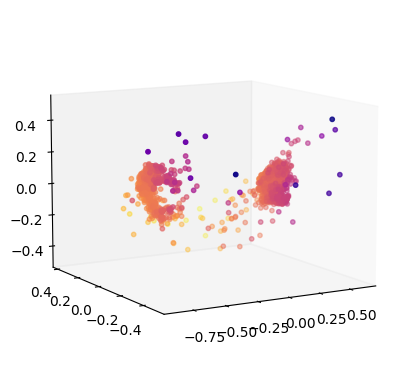

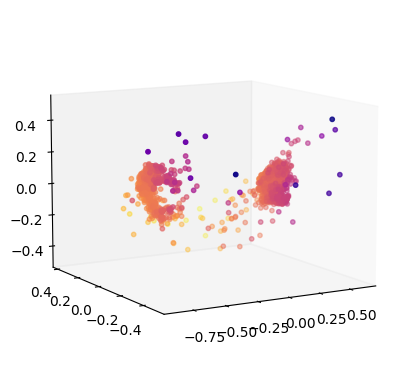

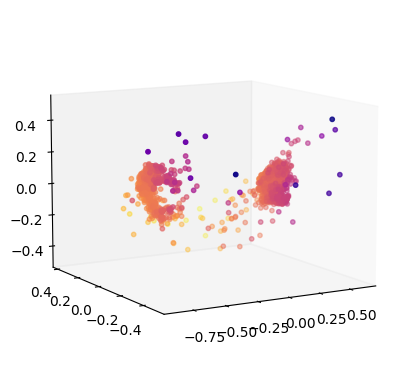

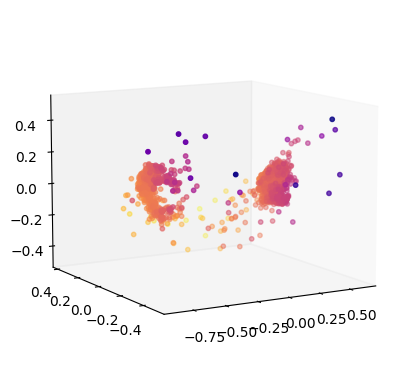

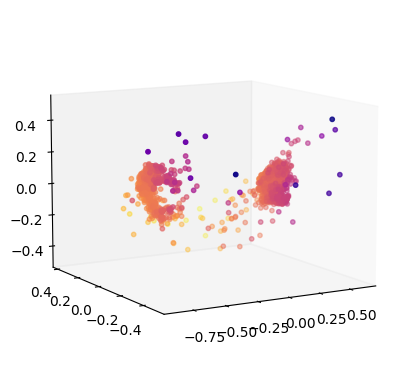

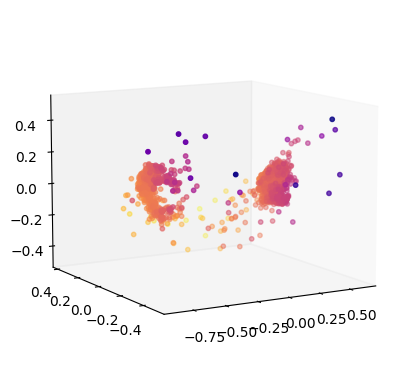

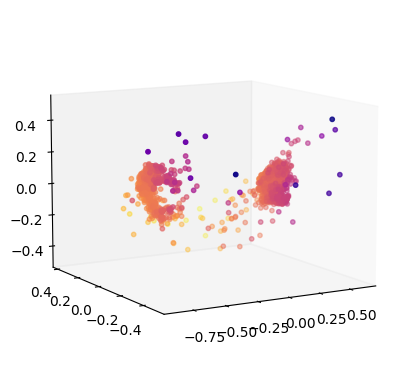

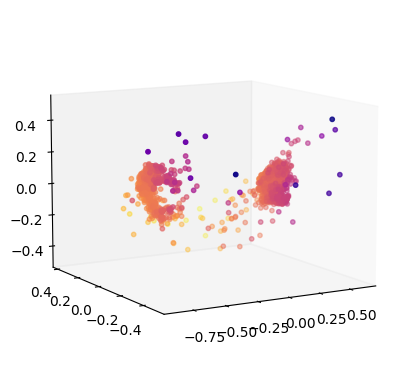

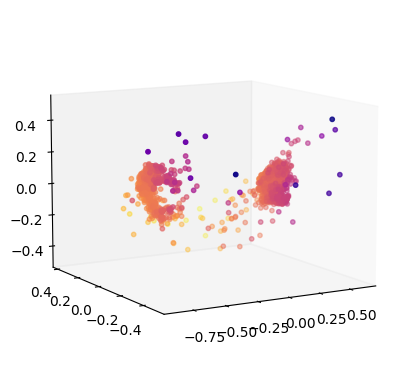

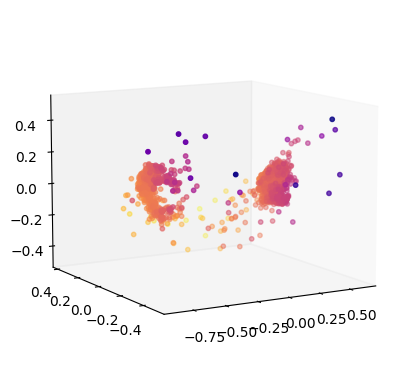

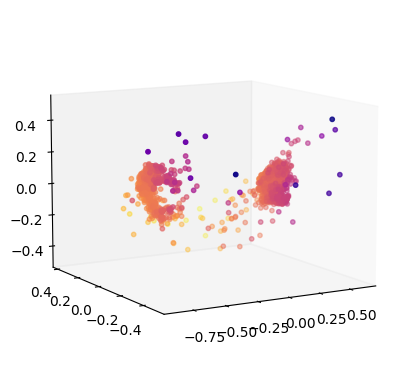

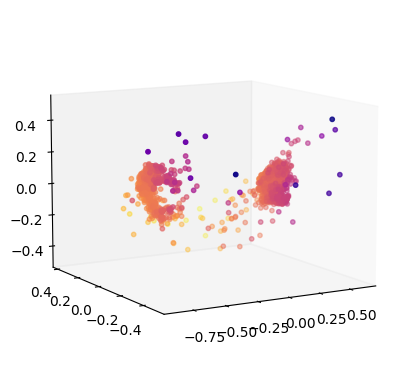

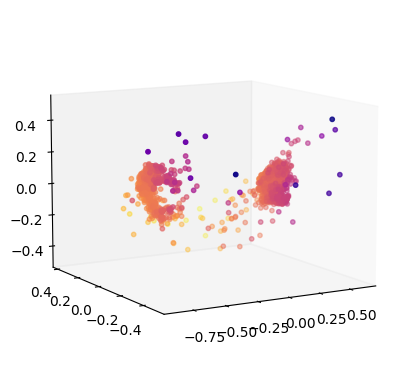

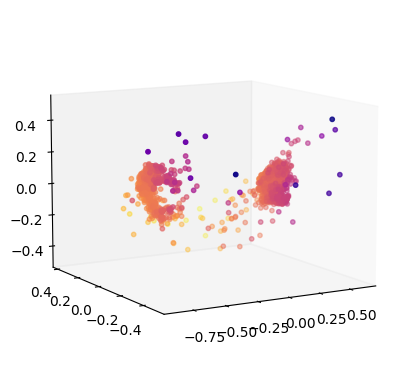

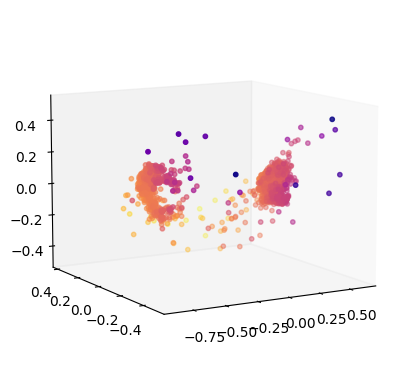

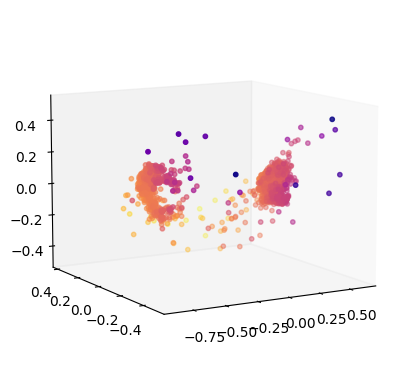

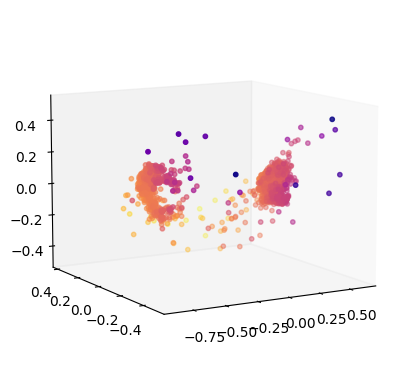

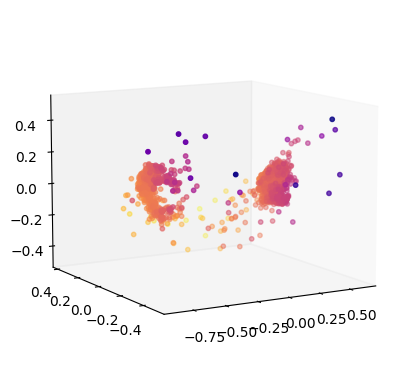

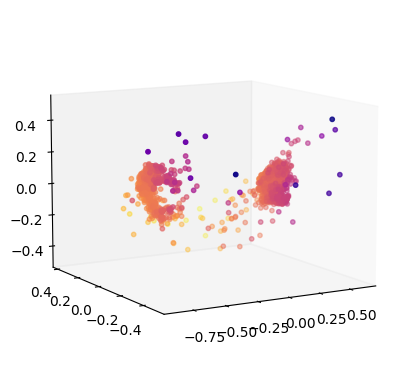

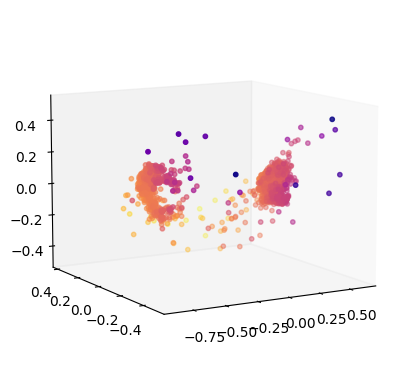

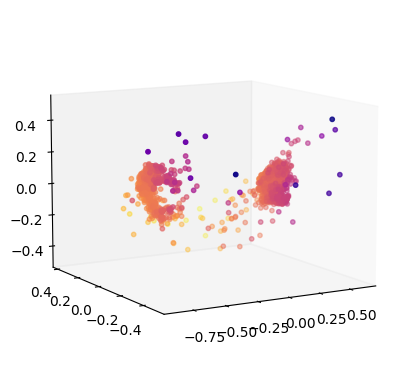

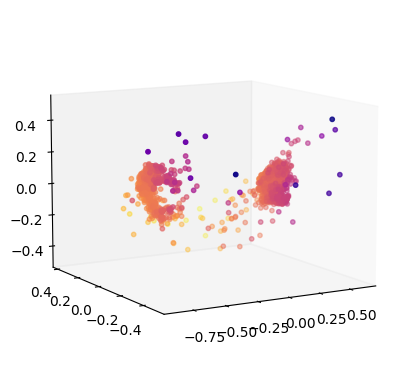

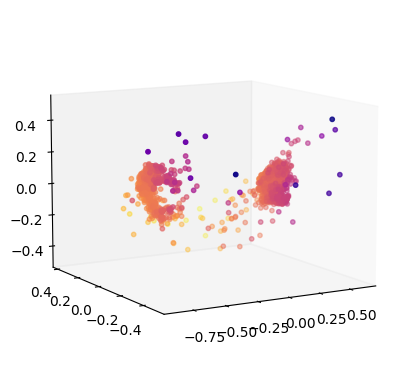

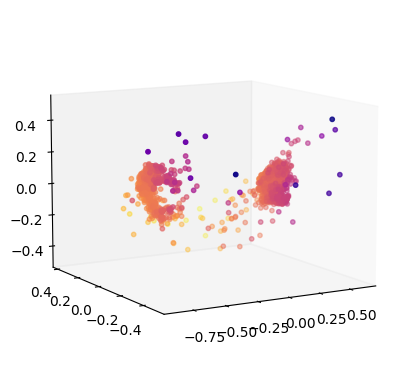

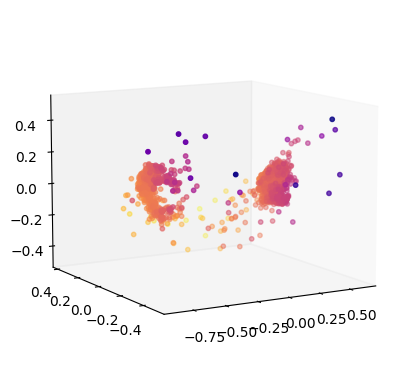

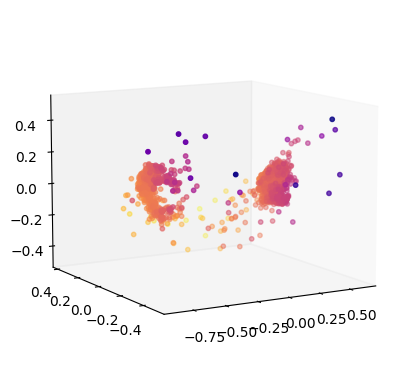

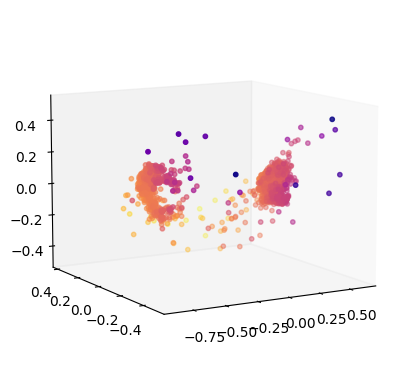

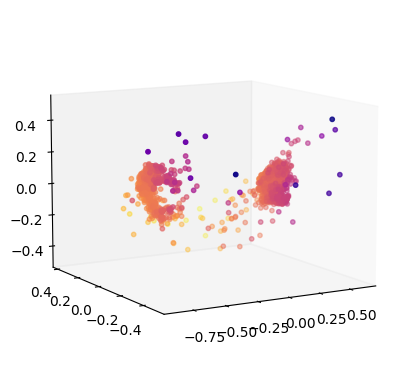

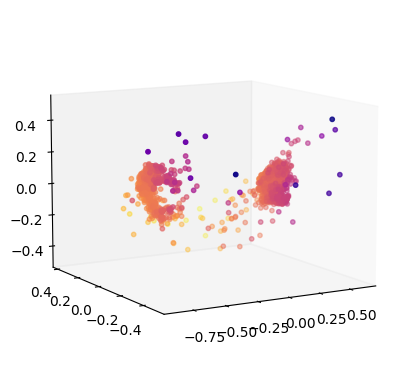

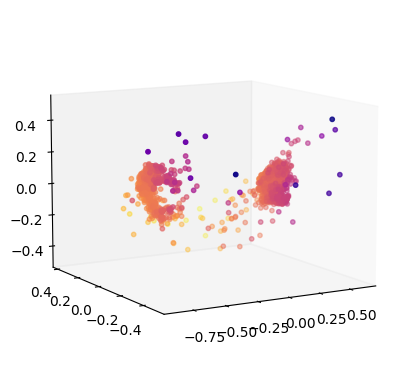

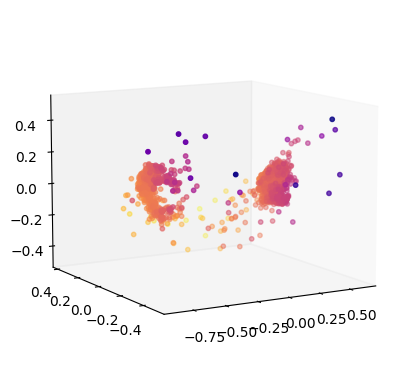

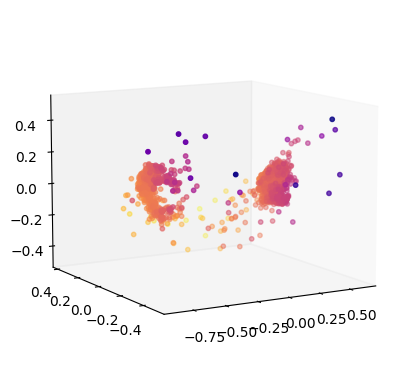

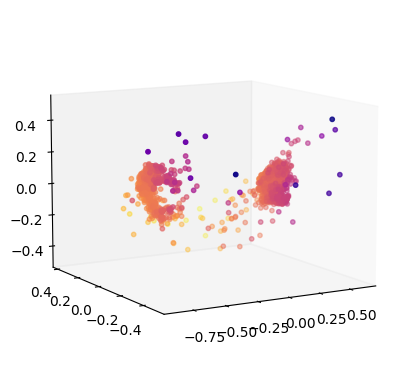

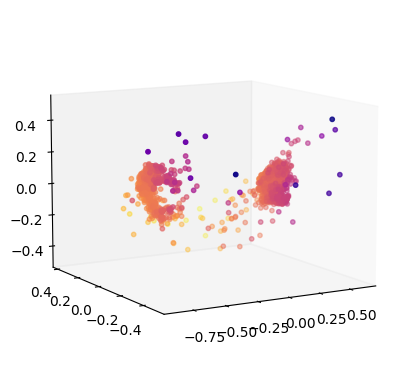

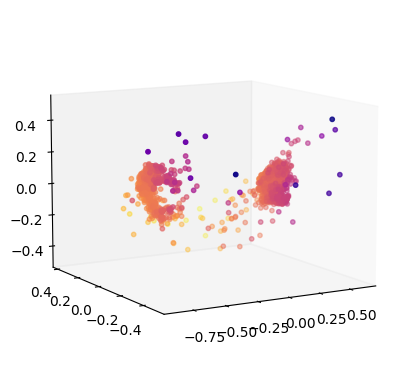

In [62]:
batch_idx, batch_data = next(enumerate(dataloader))
x = batch_data.transpose(2, 1).cpu().detach().numpy()

# sample the noise vector:
z = torch.Tensor(batch_size, raw_gan_gen_input_dim).normal_(mu, sigma).to(device)
gen_samples = raw_gan_gen(z).cpu().detach().numpy()

print(x.shape)
print(gen_samples.shape)


for i in range(batch_size):
  visualize_points(gen_samples[i].transpose(1,0), is_shapenet=True)
  # visualize_real_and_generated_samples([x[i].transpose(1,0), gen_samples[i].transpose(1,0)], is_shapenet=True)

In [63]:
visualize_points_3d(gen_samples[1].transpose(1,0))



> Save samples





In [64]:
import os
import open3d as o3d


In [65]:
output_folder = '/content/drive/MyDrive/output'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)


In [66]:
for i in range(batch_size):
    points = gen_samples[i].transpose(1, 0)  # Reshape the generated samples if needed
    output_file = os.path.join(output_folder, f'sample_{i}.ply')
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    o3d.io.write_point_cloud(output_file, pcd)
